https://pymc3-testing.readthedocs.io/en/rtd-docs/notebooks/LKJ.htmlb

In [1]:
%matplotlib inline

In [2]:
from matplotlib.patches import Ellipse
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import scipy as sp
import seaborn as sns
from theano import tensor as tt

In [3]:
np.random.seed(3264602) 

In [4]:
N = 100

mu_actual = sp.stats.uniform.rvs(-5, 10, size=2)

cov_actual_sqrt = sp.stats.uniform.rvs(0, 2, size=(2, 2))
cov_actual = np.dot(cov_actual_sqrt.T, cov_actual_sqrt)

x = sp.stats.multivariate_normal.rvs(mu_actual, cov_actual, size=N)

In [5]:
var, U = np.linalg.eig(cov_actual)
angle = 180. / np.pi * np.arccos(np.abs(U[0, 0]))

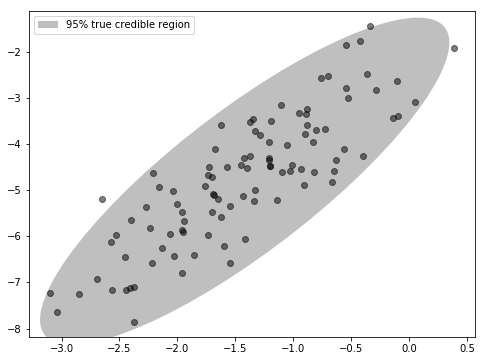

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))

blue = sns.color_palette()[0]

e = Ellipse(mu_actual, 2 * np.sqrt(5.991 * var[0]), 2 * np.sqrt(5.991 * var[1]), angle=-angle)
e.set_alpha(0.5)
e.set_facecolor('gray')
e.set_zorder(10);
ax.add_artist(e);

ax.scatter(x[:, 0], x[:, 1], c='k', alpha=0.5, zorder=11);

rect = plt.Rectangle((0, 0), 1, 1, fc='gray', alpha=0.5)
ax.legend([rect], ['95% true credible region'], loc=2);

In [8]:
init_sigma = np.std(x, axis=0)
init_corr = np.corrcoef(x, rowvar=0)[0, 1]
with pm.Model() as model:
    sigma = pm.Lognormal('sigma', np.zeros(2), np.ones(2), shape=2, testval=init_sigma)

    nu = pm.Uniform('nu', 0, 5)
    C_triu = pm.LKJCorr('C_triu', nu, 2, testval=init_corr)

In [9]:
C_triu.tag.test_value.shape

(1,)

In [11]:
with model:
    C = pm.Deterministic('C', tt.fill_diagonal(C_triu[np.zeros((2, 2), dtype=np.int64)], 1.))

    sigma_diag = pm.Deterministic('sigma_mat', tt.nlinalg.diag(sigma))
    cov = pm.Deterministic('cov', tt.nlinalg.matrix_dot(sigma_diag, C, sigma_diag))

In [12]:
with model:
    mu = pm.MvNormal('mu', 0, cov, shape=2, testval=np.mean(x, axis=0))

    x_ = pm.MvNormal('x', mu, cov, observed=x)

In [13]:
n_samples = 4000

In [14]:
with model:
    trace_ = pm.sample(n_samples, pm.Metropolis())

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [C_triu]
>Metropolis: [nu]
>Metropolis: [sigma]
Sampling 4 chains: 100%|██████████| 18000/18000 [00:09<00:00, 1963.79draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [16]:
trace = trace_[50:]

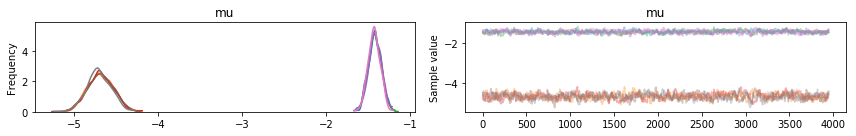

In [17]:
pm.traceplot(trace, varnames=['mu']);

In [18]:
mu_actual

array([-1.41866859, -4.8018335 ])

In [20]:
dim = 2

In [22]:
# We will use separate priors for sigma and correlation matrix.
# In order to convert the upper triangular correlation values to a
# complete correlation matrix, we need to construct an index matrix:
n_elem = dim * (dim - 1) / 2
tri_index = np.zeros([dim, dim], dtype=int)
tri_index[np.triu_indices(dim, k=1)] = np.arange(n_elem)
tri_index[np.triu_indices(dim, k=1)[::-1]] = np.arange(n_elem)

In [23]:
with pm.Model() as model_al:
    sigma = pm.HalfCauchy('sigma',beta=[2, 2],shape=dim)
    corr_triu = pm.LKJCorr('corr_triu', n=dim, eta=2)
    corr = pm.Deterministic('corr', tt.fill_diagonal(corr_triu[tri_index], 1.))
    sigma_diag = pm.Deterministic('sigma_mat', tt.nlinalg.diag(sigma))
    cov = pm.Deterministic('cov', tt.nlinalg.matrix_dot(sigma_diag, corr, sigma_diag))
    mu = pm.MvNormal('mu', 0, cov, shape=2)
    x_ = pm.MvNormal('x', mu, cov, observed=x)
    trace_alt = pm.sample(n_samples, pm.Metropolis())

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [corr_triu]
>Metropolis: [sigma]
Sampling 4 chains: 100%|██████████| 18000/18000 [00:07<00:00, 2485.77draws/s]
The number of effective samples is smaller than 10% for some parameters.


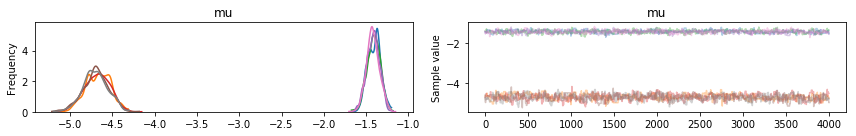

In [24]:
pm.traceplot(trace_alt, varnames=['mu']);